In [5]:
import torch 
from torch import nn 
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchvision.models as models

import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay

from torch.optim import Adam, RMSprop
import numpy as np

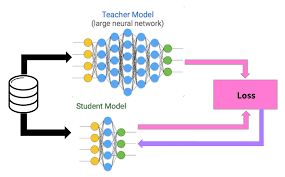
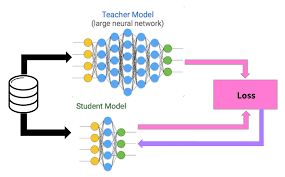
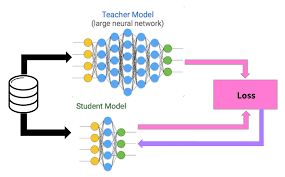
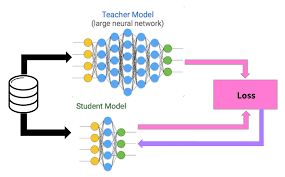

Bacis idea of knowladge distillation is to train smaller student-model, based on logits of more advanced teacher model to econom space. Learning of student model is based on common loss calculation, which is realized with Kullback–Leibler (KL) divergence to define differance between distribution of student and teacher model prediction. Here is an exapmle of this method realisation with classification of landscape types. 

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [7]:
device

'cuda'

In [8]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=45),
    transforms.ToTensor(),
    
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    
])

In [9]:
train_link = "/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Training Data"
val_link = "/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Validation Data"
test_link = "/kaggle/input/landscape-recognition-image-dataset-12k-images/Landscape Classification/Landscape Classification/Testing Data"

In [11]:
train_data = datasets.ImageFolder(train_link, transform = train_transform)
val_data = datasets.ImageFolder(val_link, transform = val_transform)
test_data = datasets.ImageFolder(test_link, transform = test_transform)

In [12]:
x, y = train_data[0]
print(x.shape)

torch.Size([3, 256, 256])


In [13]:
names = train_data.classes

In [14]:
def output(data, limit):
    for i, (x, y) in enumerate(data):
        x = x.permute(1, 2, 0)
        plt.imshow(x)
        plt.title(names[int(y)])
        plt.axis("off")
        plt.show()
    
        if i+1 >= limit:
            break

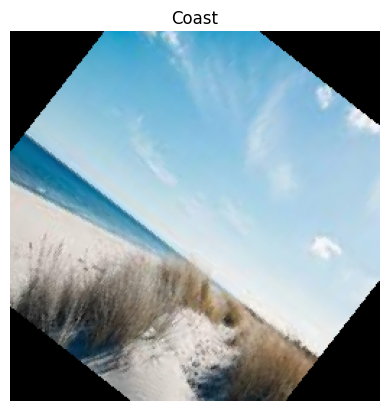

In [15]:
output(train_data, 1)

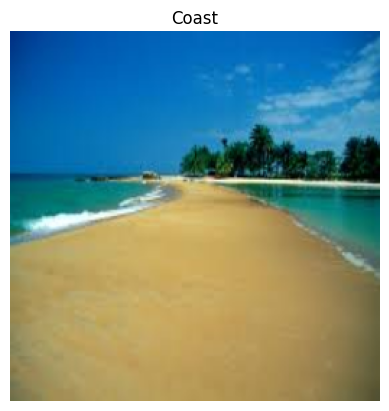

In [16]:
output(val_data, 1)

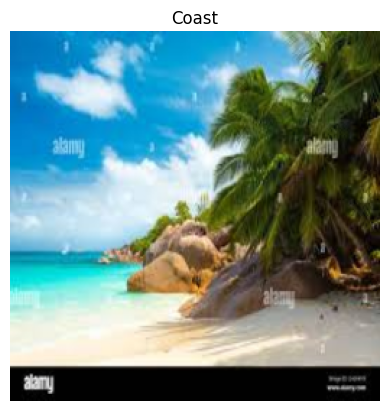

In [17]:
output(test_data, 1)

In [19]:
batch_size = 128
train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [22]:
len(names)

5

As a teacher one, I'll use an efficientnet_b3 model, which is pretty large, but suits well for this task, which requires a really deep and advanced network. 

In [32]:
class TeacherModel(nn.Module):
    def __init__(self, outputs=5):
        super().__init__()

       
        self.basic_model = models.efficientnet_b3(pretrained=True)
        self.feature_dim = self.basic_model.classifier[1].in_features
        self.basic_model.classifier = nn.Identity()
        # self.basic_model.fc = nn.Identity()

        self.classifier = nn.Sequential(
            nn.Linear(1536, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, outputs)
        )

    def forward(self, x):
        out = self.basic_model(x)
        res = self.classifier(out)
        return res

    def predict(self, x):
        self.eval()

        with torch.no_grad():
            if len(x.shape) == 3:
                x = x.unsqueeze(0)
            out = self.forward(x)
            out = torch.softmax(out, dim=1)
            res = torch.argmax(out).item()
            return res

In [33]:
teacher_model = TeacherModel()

In [34]:
for param in teacher_model.basic_model.parameters():
    param.requires_grad = False


for param in teacher_model.basic_model.classifier.parameters():
    param.requires_grad = True

In [35]:
# model = Classifier()
teacher_model.to(device)
# model.eval()
tensor = torch.rand(1, 3, 256, 256).to(device)

out = teacher_model(tensor)
out

tensor([[-0.0525, -0.0857, -0.0123,  0.0233,  0.0452]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [36]:
tensor = torch.rand(3, 256, 256).to(device)
res = teacher_model.predict(tensor)
res

4

In [37]:
tensor = torch.rand(1, 3, 256, 256).to(device)
res = teacher_model.predict(tensor)
res

4

Total weight of model is 488 MB, which is pretty much, but this helps to handle the task quite good. 

In [38]:
summary(teacher_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 40, 128, 128]           1,080
       BatchNorm2d-2         [-1, 40, 128, 128]              80
              SiLU-3         [-1, 40, 128, 128]               0
            Conv2d-4         [-1, 40, 128, 128]             360
       BatchNorm2d-5         [-1, 40, 128, 128]              80
              SiLU-6         [-1, 40, 128, 128]               0
 AdaptiveAvgPool2d-7             [-1, 40, 1, 1]               0
            Conv2d-8             [-1, 10, 1, 1]             410
              SiLU-9             [-1, 10, 1, 1]               0
           Conv2d-10             [-1, 40, 1, 1]             440
          Sigmoid-11             [-1, 40, 1, 1]               0
SqueezeExcitation-12         [-1, 40, 128, 128]               0
           Conv2d-13         [-1, 24, 128, 128]             960
      BatchNorm2d-14         [-1, 24, 1

In [39]:
def train(model, train_dl, val_dl, optimizer, loss_fn, epochs, device):
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            output = model(x)

            loss = loss_fn(output, y)

            # important to use that during accuracy calculation 
            preds = torch.argmax(output, dim=1)
            acc = accuracy_score(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
            
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += acc.item()

        total_train_loss = train_loss / len(train_dl)
        total_train_acc = train_acc/ len(train_dl)

        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)

                output = model(x)
                loss = loss_fn(output, y)

                preds = torch.argmax(output, dim=1)
                acc = accuracy_score(preds.detach().cpu().numpy(), y.detach().cpu().numpy())

                val_loss += loss.item()
                val_acc += acc
                

        
        total_val_loss = val_loss / len(val_dl)
        total_val_acc = val_acc / len(val_dl)

        history["train_loss"].append(total_train_loss)
        history["train_acc"].append(total_train_acc)

        history["val_loss"].append(total_val_loss)
        history["val_acc"].append(total_val_acc)

        print(f'Epoch: {epoch+1}; Loss: {total_train_loss:.4f}; Accuracy: {total_train_acc:.4f}; Val_loss: {total_val_loss:.4f}; Val_acc: {total_val_acc:.4f}')
    
    return history           
        

In [40]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(teacher_model.parameters(), lr=1e-3, weight_decay=1e-4)

In [41]:
history = train(teacher_model, train_dl, val_dl, optimizer, loss_fn, 40, device)

100%|██████████| 12/12 [00:20<00:00,  1.71s/it]


Epoch: 1; Loss: 0.9089; Accuracy: 0.6768; Val_loss: 0.7276; Val_acc: 0.7428


100%|██████████| 12/12 [00:08<00:00,  1.35it/s]


Epoch: 2; Loss: 0.6563; Accuracy: 0.7659; Val_loss: 0.6995; Val_acc: 0.7384


100%|██████████| 12/12 [00:10<00:00,  1.13it/s]


Epoch: 3; Loss: 0.6114; Accuracy: 0.7795; Val_loss: 0.6934; Val_acc: 0.7461


100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Epoch: 4; Loss: 0.5779; Accuracy: 0.7932; Val_loss: 0.6812; Val_acc: 0.7440


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch: 5; Loss: 0.5701; Accuracy: 0.7956; Val_loss: 0.6456; Val_acc: 0.7632


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch: 6; Loss: 0.5517; Accuracy: 0.7996; Val_loss: 0.6595; Val_acc: 0.7613


100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch: 7; Loss: 0.5350; Accuracy: 0.8048; Val_loss: 0.6433; Val_acc: 0.7617


100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch: 8; Loss: 0.5294; Accuracy: 0.8103; Val_loss: 0.7993; Val_acc: 0.7576


100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch: 9; Loss: 0.5174; Accuracy: 0.8101; Val_loss: 0.6288; Val_acc: 0.7704


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 10; Loss: 0.5094; Accuracy: 0.8124; Val_loss: 0.6196; Val_acc: 0.7661


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


Epoch: 11; Loss: 0.4974; Accuracy: 0.8178; Val_loss: 0.6284; Val_acc: 0.7646


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 12; Loss: 0.4927; Accuracy: 0.8209; Val_loss: 0.6265; Val_acc: 0.7683


100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch: 13; Loss: 0.5014; Accuracy: 0.8123; Val_loss: 0.6386; Val_acc: 0.7612


100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


Epoch: 14; Loss: 0.4879; Accuracy: 0.8218; Val_loss: 0.6616; Val_acc: 0.7522


100%|██████████| 12/12 [00:06<00:00,  1.71it/s]


Epoch: 15; Loss: 0.4776; Accuracy: 0.8230; Val_loss: 0.6643; Val_acc: 0.7614


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch: 16; Loss: 0.4867; Accuracy: 0.8227; Val_loss: 0.6963; Val_acc: 0.7670


100%|██████████| 12/12 [00:07<00:00,  1.69it/s]


Epoch: 17; Loss: 0.4753; Accuracy: 0.8269; Val_loss: 0.6061; Val_acc: 0.7841


100%|██████████| 12/12 [00:07<00:00,  1.71it/s]


Epoch: 18; Loss: 0.4589; Accuracy: 0.8288; Val_loss: 0.6132; Val_acc: 0.7782


100%|██████████| 12/12 [00:07<00:00,  1.70it/s]


Epoch: 19; Loss: 0.4543; Accuracy: 0.8289; Val_loss: 0.6232; Val_acc: 0.7726


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch: 20; Loss: 0.4530; Accuracy: 0.8352; Val_loss: 0.6219; Val_acc: 0.7752


100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Epoch: 21; Loss: 0.4370; Accuracy: 0.8399; Val_loss: 0.6165; Val_acc: 0.7726


100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Epoch: 22; Loss: 0.4447; Accuracy: 0.8350; Val_loss: 0.6089; Val_acc: 0.7701


100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


Epoch: 23; Loss: 0.4366; Accuracy: 0.8388; Val_loss: 0.6137; Val_acc: 0.7783


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch: 24; Loss: 0.4393; Accuracy: 0.8373; Val_loss: 0.6114; Val_acc: 0.7679


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 25; Loss: 0.4296; Accuracy: 0.8441; Val_loss: 0.6196; Val_acc: 0.7731


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 26; Loss: 0.4333; Accuracy: 0.8428; Val_loss: 0.6195; Val_acc: 0.7769


100%|██████████| 12/12 [00:06<00:00,  1.74it/s]


Epoch: 27; Loss: 0.4220; Accuracy: 0.8440; Val_loss: 0.6005; Val_acc: 0.7709


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 28; Loss: 0.4157; Accuracy: 0.8485; Val_loss: 0.6482; Val_acc: 0.7722


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Epoch: 29; Loss: 0.4044; Accuracy: 0.8527; Val_loss: 0.6335; Val_acc: 0.7718


100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Epoch: 30; Loss: 0.4223; Accuracy: 0.8419; Val_loss: 0.6328; Val_acc: 0.7740


100%|██████████| 12/12 [00:07<00:00,  1.65it/s]


Epoch: 31; Loss: 0.4168; Accuracy: 0.8484; Val_loss: 0.6171; Val_acc: 0.7783


100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


Epoch: 32; Loss: 0.4116; Accuracy: 0.8458; Val_loss: 0.6433; Val_acc: 0.7805


100%|██████████| 12/12 [00:07<00:00,  1.61it/s]


Epoch: 33; Loss: 0.4104; Accuracy: 0.8479; Val_loss: 0.7064; Val_acc: 0.7678


100%|██████████| 12/12 [00:07<00:00,  1.62it/s]


Epoch: 34; Loss: 0.4062; Accuracy: 0.8515; Val_loss: 0.6215; Val_acc: 0.7698


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch: 35; Loss: 0.3929; Accuracy: 0.8567; Val_loss: 0.6183; Val_acc: 0.7853


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch: 36; Loss: 0.4085; Accuracy: 0.8500; Val_loss: 0.6072; Val_acc: 0.7817


100%|██████████| 12/12 [00:07<00:00,  1.51it/s]


Epoch: 37; Loss: 0.3939; Accuracy: 0.8553; Val_loss: 0.6288; Val_acc: 0.7764


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]


Epoch: 38; Loss: 0.4093; Accuracy: 0.8490; Val_loss: 0.5924; Val_acc: 0.7837


100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


Epoch: 39; Loss: 0.3952; Accuracy: 0.8541; Val_loss: 0.6371; Val_acc: 0.7732


100%|██████████| 12/12 [00:07<00:00,  1.67it/s]

Epoch: 40; Loss: 0.3927; Accuracy: 0.8575; Val_loss: 0.6490; Val_acc: 0.7717


In [42]:
test_dl = DataLoader(test_data, batch_size=32, shuffle=False)

100%|██████████| 16/16 [00:06<00:00,  2.43it/s]


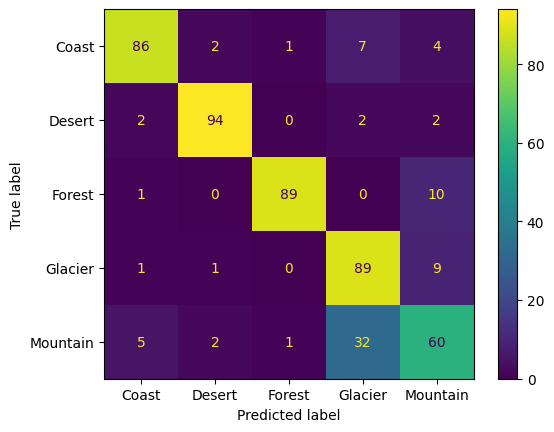

In [43]:
teacher_model.eval()

y_true = []
y_preds = []

with torch.no_grad():
    for x, y in tqdm(test_dl):
        x = x.to(device)
        y = y.to(device)

        preds = teacher_model(x)

        y_pred = torch.argmax(preds, dim=1)
        
        y_true.extend(y.cpu().numpy())
        y_preds.extend(y_pred.cpu().numpy())

y_true = np.array(y_true)
y_preds = np.array(y_preds)

ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels=names)
        

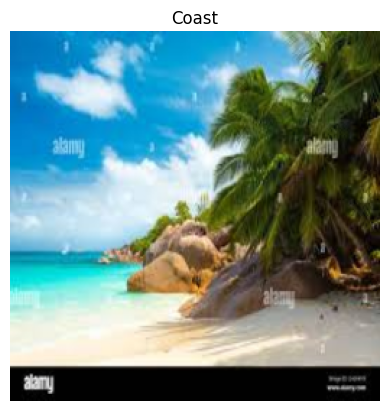

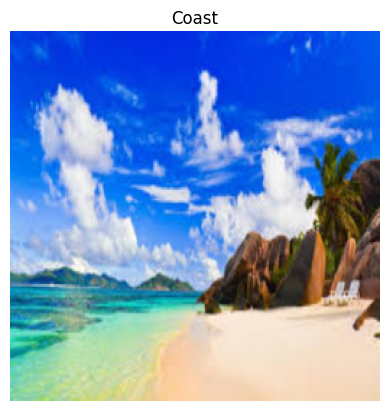

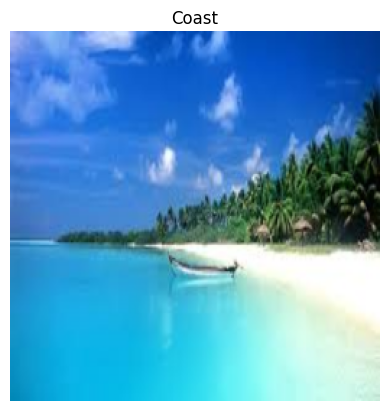

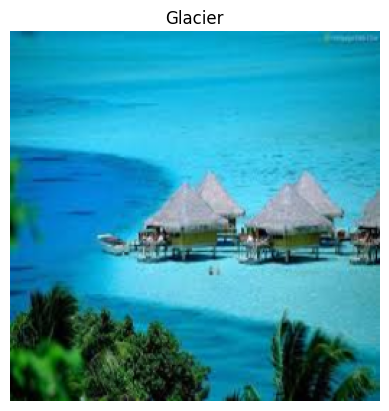

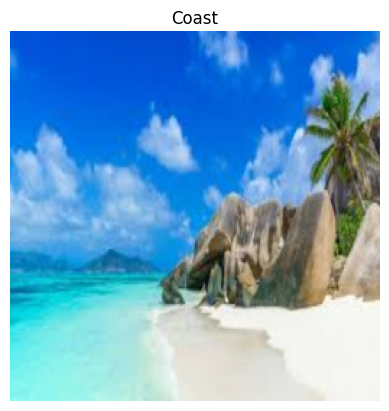

In [44]:
for i, (x, y) in enumerate(test_data):
    x = x.to(device)
    pred = teacher_model.predict(x)
    img = x.permute(1, 2, 0).cpu().numpy()
    name = names[int(pred)]
    plt.imshow(img)
    plt.title(name)
    plt.axis("off")
    plt.show()

    if i+1 >= 5:
        break

In [49]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding)
        self.bnorm1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3,
                              stride=1, padding=1)
        self.bnorm2 = nn.BatchNorm2d(out_channels)

        if in_channels != out_channels:
            
            self.add_conv = nn.Sequential(
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size,
                              stride=stride, padding=padding),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.bnorm1(self.conv1(x))
        add_out = self.add_conv(x)
        
        out = F.relu(out)
        out = self.bnorm2(self.conv2(out))
        out += add_out 
        out = F.relu(out)
        return out

In [50]:
res_block = ResBlock(3, 32, 4, 2, 1)
tensor = torch.rand(1, 3, 256, 256)

out = res_block(tensor)
out.shape

torch.Size([1, 32, 128, 128])

Here we build a custom student-model, which weight will be near 40 MB, so in 10 times less, then teacher has. 

In [54]:
class StudentModel(nn.Module):
    def __init__(self, outputs=5):
        super().__init__()

        self.conv1 = ResBlock(3, 32, 4, 2, 1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.bnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.bnorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.bnorm4 = nn.BatchNorm2d(256)

        self.aap = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()

        self.linear1 = nn.Linear(256, 32)
        self.dropout = nn.Dropout(0.3)
        self.linear2 = nn.Linear(32, outputs)

    def forward(self, x):
        out = self.conv1(x)
        out = F.relu(self.bnorm2(self.conv2(out)))
        out = F.relu(self.bnorm3(self.conv3(out)))
        out = F.relu(self.bnorm4(self.conv4(out)))

        out = self.aap(out)
        out = self.flatten(out)

        out = self.dropout(F.relu(self.linear1(out)))
        res = self.linear2(out)

        return res

    def predict(self, x):
        self.eval()

        with torch.no_grad():
            if len(x.shape) == 3:
                x = x.unsqueeze(0)
                
            pred = self.forward(x)
            pred = torch.softmax(pred, dim=1)
            res = torch.argmax(pred).item()

        return res 
        

In [64]:
student_model = StudentModel()
student_model.to(device)

StudentModel(
  (conv1): ResBlock(
    (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (bnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (add_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 

In [65]:
summary(student_model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,568
       BatchNorm2d-2         [-1, 32, 128, 128]              64
            Conv2d-3         [-1, 32, 128, 128]           1,568
       BatchNorm2d-4         [-1, 32, 128, 128]              64
            Conv2d-5         [-1, 32, 128, 128]           9,248
       BatchNorm2d-6         [-1, 32, 128, 128]              64
          ResBlock-7         [-1, 32, 128, 128]               0
            Conv2d-8           [-1, 64, 64, 64]          32,832
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10          [-1, 128, 32, 32]         131,200
      BatchNorm2d-11          [-1, 128, 32, 32]             256
           Conv2d-12          [-1, 256, 16, 16]         524,544
      BatchNorm2d-13          [-1, 256, 16, 16]             512
AdaptiveAvgPool2d-14            [-1, 25

In [66]:
tensor = torch.rand(3, 256, 256).to(device)

res = student_model.predict(tensor)
print(res)

2


In [67]:
new_optimizer = Adam(student_model.parameters(), lr=1e-3, weight_decay=1e-5)

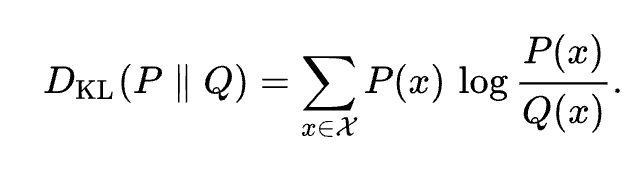
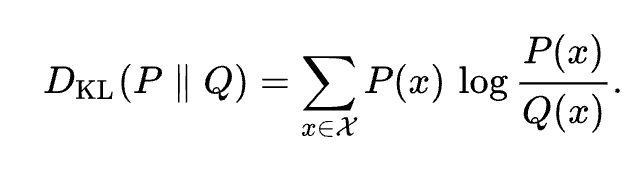

In PyTorch we realize knowladge distillation during training og student model. Commom loss function of both models requires calculation of hard and soft losses. Hard loss - is normal loss of student model (CrossEntropyLoss in this case) and the most difficult and important part is soft loss, which above mentioned Kullback–Leibler (KL) divergence between teacher and student models predictions (there is a formula on an image above):

*soft_loss = kl_div(
                F.log_softmax(student_preds / T, dim=1),
                F.softmax(teacher_preds / T, dim=1))*

Then we combine both losses and calculate them according to formula:

*loss = a * hard_loss + (1 - a) * soft_loss * T**2*

Where:
a - is alpha regularization weight (usually near 0.5)
and T - temperature coeficient (usually more than 1.0)

**! So we realize knowladge distillation only during training of student model. Validation part remaines with no changes.** 


In [68]:
kl_div = nn.KLDivLoss(reduction='batchmean') 
loss_fn = nn.CrossEntropyLoss()

In [69]:
def distillation_train(student_model, teacher_model, train_dl, val_dl, optimizer, loss_fn, kl_div, epochs, device, 
                      a = 0.5, T = 2.0):
    history = {
        "train_loss": [],
        "train_acc": [],

        "val_loss": [],
        "val_acc": []
    }

    for epoch in range(epochs):
        student_model.train()
        train_loss = 0.0
        train_acc = 0.0

        for x, y in tqdm(train_dl):
            x = x.to(device)
            y = y.to(device)

            optimizer.zero_grad()

            student_preds = student_model(x)

            with torch.no_grad():
                teacher_preds = teacher_model(x)

            hard_loss = loss_fn(student_preds, y)
            soft_loss = kl_div(
                F.log_softmax(student_preds / T, dim=1),
                F.softmax(teacher_preds / T, dim=1)
            )

            loss = a * hard_loss + (1 - a) * (soft_loss * T**2)
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()

            student_preds = torch.argmax(student_preds, dim=1)
            acc = accuracy_score(student_preds.detach().cpu().numpy(), y.detach().cpu().numpy())
            train_acc += acc.item()

        total_train_loss = train_loss / len(train_dl)
        total_train_acc = train_acc / len(train_dl)

        student_model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for x, y in tqdm(val_dl):
                x = x.to(device)
                y = y.to(device)
    
                preds = student_model(x)
                loss = loss_fn(preds, y)
                val_loss += loss.item()
    
                preds = torch.argmax(preds, dim=1)
                acc = accuracy_score(preds.detach().cpu().numpy(), y.detach().cpu().numpy())
                val_acc += acc.item()

        total_val_loss = val_loss / len(val_dl)
        total_val_acc = val_acc / len(val_dl)

        history["train_loss"].append(total_train_loss)
        history["train_acc"].append(total_train_acc)

        history["val_loss"].append(total_val_loss)
        history["val_acc"].append(total_val_acc)

        print(f'Epoch: {epoch+1}; Loss: {total_train_loss:.4f}; Accuracy: {total_train_acc:.4f}; Val_loss: {total_val_loss:.4f}; Val_acc: {total_val_acc:.4f}')
    
    return history
    

In [70]:
history = distillation_train(student_model, teacher_model, train_dl, val_dl, new_optimizer, loss_fn, kl_div, 40, device)

100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Epoch: 1; Loss: 1.5631; Accuracy: 0.5870; Val_loss: 1.9226; Val_acc: 0.4950


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]


Epoch: 2; Loss: 1.3457; Accuracy: 0.6451; Val_loss: 1.0623; Val_acc: 0.6224


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch: 3; Loss: 1.2719; Accuracy: 0.6703; Val_loss: 1.1481; Val_acc: 0.5843


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch: 4; Loss: 1.1947; Accuracy: 0.6897; Val_loss: 1.2101; Val_acc: 0.5974


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch: 5; Loss: 1.1853; Accuracy: 0.6951; Val_loss: 0.9275; Val_acc: 0.6489


100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


Epoch: 6; Loss: 1.1655; Accuracy: 0.6977; Val_loss: 1.1176; Val_acc: 0.6085


100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


Epoch: 7; Loss: 1.1153; Accuracy: 0.7149; Val_loss: 1.0137; Val_acc: 0.6332


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch: 8; Loss: 1.1014; Accuracy: 0.7200; Val_loss: 0.9276; Val_acc: 0.6525


100%|██████████| 12/12 [00:05<00:00,  2.22it/s]


Epoch: 9; Loss: 1.1030; Accuracy: 0.7184; Val_loss: 0.8570; Val_acc: 0.6690


100%|██████████| 12/12 [00:05<00:00,  2.27it/s]


Epoch: 10; Loss: 1.0541; Accuracy: 0.7298; Val_loss: 1.2019; Val_acc: 0.5844


100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


Epoch: 11; Loss: 1.0646; Accuracy: 0.7242; Val_loss: 0.9165; Val_acc: 0.6745


100%|██████████| 12/12 [00:04<00:00,  2.43it/s]


Epoch: 12; Loss: 1.0346; Accuracy: 0.7356; Val_loss: 0.7884; Val_acc: 0.6859


100%|██████████| 12/12 [00:04<00:00,  2.41it/s]


Epoch: 13; Loss: 1.0404; Accuracy: 0.7340; Val_loss: 0.9613; Val_acc: 0.6602


100%|██████████| 12/12 [00:05<00:00,  2.40it/s]


Epoch: 14; Loss: 1.0051; Accuracy: 0.7460; Val_loss: 0.9047; Val_acc: 0.6712


100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch: 15; Loss: 0.9966; Accuracy: 0.7473; Val_loss: 1.1895; Val_acc: 0.5603


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch: 16; Loss: 0.9916; Accuracy: 0.7477; Val_loss: 0.9350; Val_acc: 0.6895


100%|██████████| 12/12 [00:05<00:00,  2.30it/s]


Epoch: 17; Loss: 0.9697; Accuracy: 0.7552; Val_loss: 0.8029; Val_acc: 0.7169


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


Epoch: 18; Loss: 0.9648; Accuracy: 0.7572; Val_loss: 0.8898; Val_acc: 0.6767


100%|██████████| 12/12 [00:06<00:00,  1.90it/s]


Epoch: 19; Loss: 0.9635; Accuracy: 0.7574; Val_loss: 0.7860; Val_acc: 0.7124


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


Epoch: 20; Loss: 0.9604; Accuracy: 0.7568; Val_loss: 0.7863; Val_acc: 0.7204


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Epoch: 21; Loss: 0.9468; Accuracy: 0.7593; Val_loss: 1.0229; Val_acc: 0.6370


100%|██████████| 12/12 [00:05<00:00,  2.34it/s]


Epoch: 22; Loss: 0.9556; Accuracy: 0.7621; Val_loss: 0.8024; Val_acc: 0.7103


100%|██████████| 12/12 [00:05<00:00,  2.36it/s]


Epoch: 23; Loss: 0.9226; Accuracy: 0.7672; Val_loss: 0.8365; Val_acc: 0.6913


100%|██████████| 12/12 [00:04<00:00,  2.40it/s]


Epoch: 24; Loss: 0.9055; Accuracy: 0.7725; Val_loss: 0.8142; Val_acc: 0.7097


100%|██████████| 12/12 [00:05<00:00,  2.35it/s]


Epoch: 25; Loss: 0.9067; Accuracy: 0.7787; Val_loss: 1.2522; Val_acc: 0.5858


100%|██████████| 12/12 [00:04<00:00,  2.42it/s]


Epoch: 26; Loss: 0.8802; Accuracy: 0.7768; Val_loss: 0.7834; Val_acc: 0.7165


100%|██████████| 12/12 [00:05<00:00,  2.09it/s]


Epoch: 27; Loss: 0.8857; Accuracy: 0.7798; Val_loss: 0.9744; Val_acc: 0.6889


100%|██████████| 12/12 [00:07<00:00,  1.63it/s]


Epoch: 28; Loss: 0.8899; Accuracy: 0.7776; Val_loss: 1.0382; Val_acc: 0.6210


100%|██████████| 12/12 [00:05<00:00,  2.32it/s]


Epoch: 29; Loss: 0.8701; Accuracy: 0.7819; Val_loss: 0.8472; Val_acc: 0.6786


100%|██████████| 12/12 [00:05<00:00,  2.37it/s]


Epoch: 30; Loss: 0.8795; Accuracy: 0.7832; Val_loss: 0.8007; Val_acc: 0.7206


100%|██████████| 12/12 [00:05<00:00,  2.21it/s]


Epoch: 31; Loss: 0.8667; Accuracy: 0.7878; Val_loss: 1.2117; Val_acc: 0.6053


100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


Epoch: 32; Loss: 0.8654; Accuracy: 0.7837; Val_loss: 0.7190; Val_acc: 0.7282


100%|██████████| 12/12 [00:09<00:00,  1.32it/s]


Epoch: 33; Loss: 0.8386; Accuracy: 0.7893; Val_loss: 0.8616; Val_acc: 0.6878


100%|██████████| 12/12 [00:05<00:00,  2.39it/s]


Epoch: 34; Loss: 0.8299; Accuracy: 0.7913; Val_loss: 0.7616; Val_acc: 0.7371


100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Epoch: 35; Loss: 0.8279; Accuracy: 0.7942; Val_loss: 0.9398; Val_acc: 0.6789


100%|██████████| 12/12 [00:06<00:00,  1.91it/s]


Epoch: 36; Loss: 0.8314; Accuracy: 0.7972; Val_loss: 0.7988; Val_acc: 0.7203


100%|██████████| 12/12 [00:05<00:00,  2.40it/s]


Epoch: 37; Loss: 0.8393; Accuracy: 0.7879; Val_loss: 0.8506; Val_acc: 0.6955


100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


Epoch: 38; Loss: 0.8189; Accuracy: 0.7989; Val_loss: 0.9214; Val_acc: 0.6770


100%|██████████| 12/12 [00:05<00:00,  2.17it/s]


Epoch: 39; Loss: 0.8277; Accuracy: 0.7949; Val_loss: 0.7569; Val_acc: 0.7258


100%|██████████| 12/12 [00:05<00:00,  2.25it/s]

Epoch: 40; Loss: 0.8023; Accuracy: 0.7996; Val_loss: 0.7773; Val_acc: 0.7319


In [71]:
def output_metrics(history, name):
    plt.xlabel("Epochs")
    plt.ylabel(name.upper())
    plt.plot(history[f"train_{name}"], label="train set")
    plt.plot(history[f"val_{name}"], label="validation set")
    plt.legend()
    plt.show()

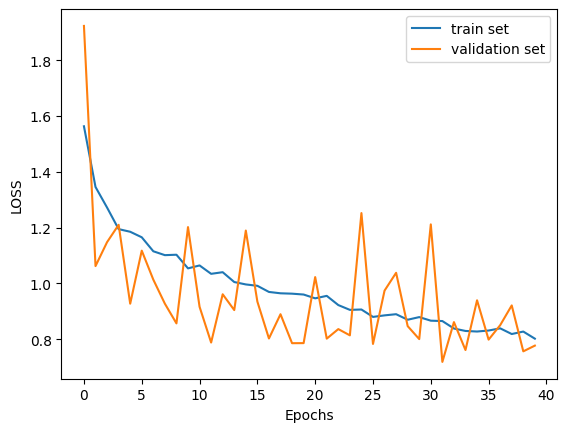

In [72]:
output_metrics(history, "loss")

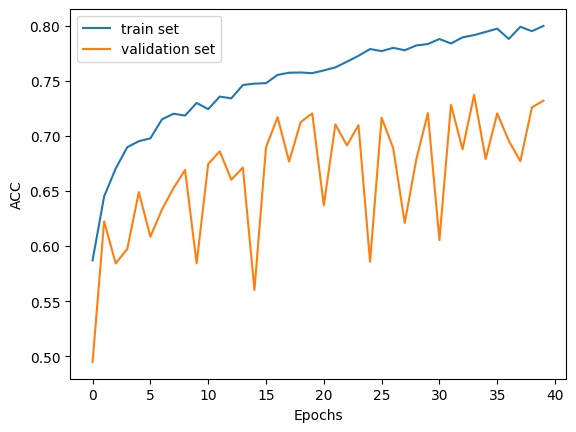

In [73]:
output_metrics(history, "acc")

100%|██████████| 16/16 [00:01<00:00,  8.01it/s]


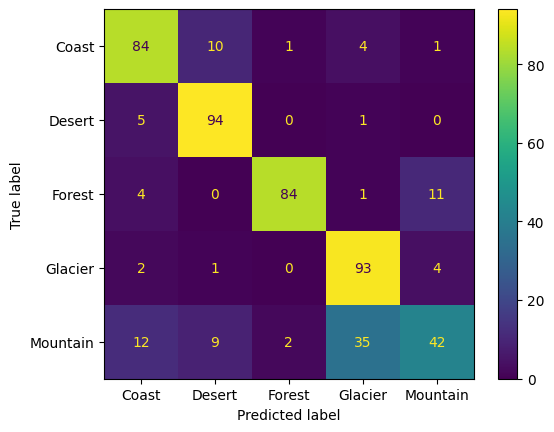

In [74]:
student_model.eval()

with torch.no_grad():

    y_preds = []
    y_trues = []

    for x, y in tqdm(test_dl):
        x = x.to(device)
        y = y.to(device)

        preds = student_model(x)

        y_pred = torch.argmax(preds, dim=1)
        y_preds.extend(y_pred.cpu().numpy())
        y_trues.extend(y.cpu().numpy())

y_preds = np.array(y_preds)
y_trues = np.array(y_trues)

ConfusionMatrixDisplay.from_predictions(y_true, y_preds, display_labels=names)
        

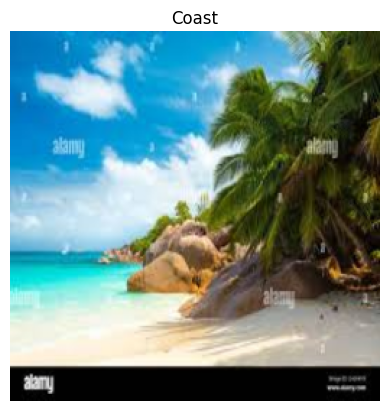

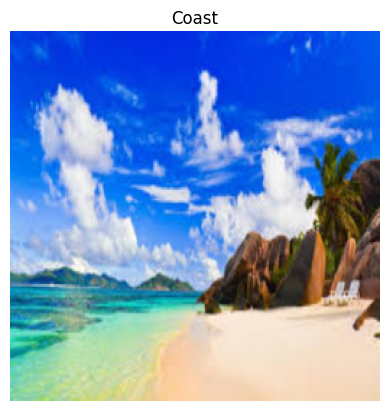

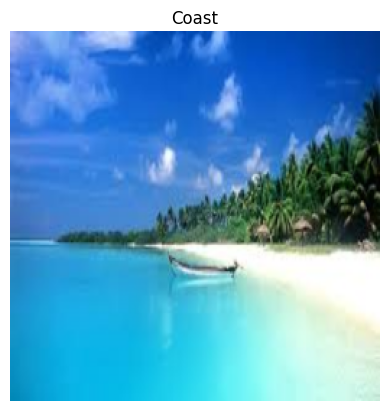

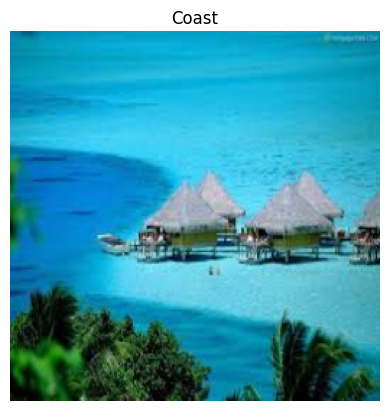

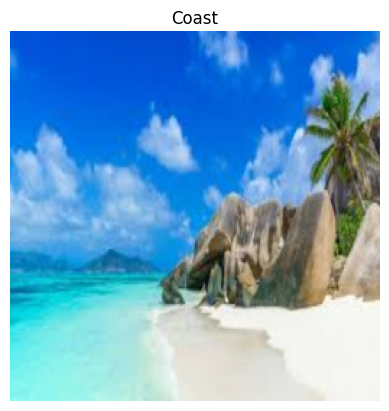

In [75]:
for i, (x, y) in enumerate(test_data):
    x = x.to(device)
    pred = student_model.predict(x)
    img = x.permute(1, 2, 0).cpu().numpy()
    name = names[int(pred)]
    plt.imshow(img)
    plt.title(name)
    plt.axis("off")
    plt.show()

    if i+1 >= 5:
        break

So as we see, that despite much smaller size of student model, it's accuracy remains pretty same, that teachers.

In [76]:
torch.save(student_model.state_dict(), "student_landscape_classifier.pt")